# Preparing Data for Linear Regression

I have been given advertising data containing information on how moeny spent on various forms of advertising corresponds to toy sales. I want to be able to use linear regression to model sales using money spent on each form of advertising. To do that, I need to make sure the data follows the basic qualifications necessary for linear regression to be doable and accurate.

## Importing Advertising Data

In [1]:
import math
import warnings
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
del data['Unnamed: 0']
display(data.head())

,TV,Radio,Newspaper,Sales
0,230.100,37.800,69.200,22.100
1,44.500,39.300,45.100,10.400
2,17.200,45.900,69.300,9.300
3,151.500,41.300,58.500,18.500
4,180.800,10.800,58.400,12.900


In [3]:
features = pd.DataFrame()
#Add in Newspaper and other transformations as well, may be useful later
features['Sales'] = data['Sales']
features['TV'] = data['TV']
features['Radio'] = data['Radio']
features['Newspaper'] = data['Newspaper']
features['Sales_Sqrt'] = np.sqrt(data['Sales'])
features['TV_Sqrt'] = np.sqrt(data['TV'])
features['Radio_Sqrt'] = np.sqrt(data['Radio'])
features['Newspaper_Sqrt'] = np.sqrt(data['Newspaper'])
#Remove any infinite values
features = features.replace([np.inf, -np.inf], np.nan)
features.dropna(inplace=True)
#Create a dateframe for log transformations, may be useful later
log_features = pd.DataFrame()
log_features['Sales'] = data['Sales']
log_features['TV'] = data['TV']
log_features['Radio'] = data['Radio']
log_features['Newspaper'] = data['Newspaper']
log_features['Sales_Log'] = np.log(data['Sales'])
log_features['TV_Log'] = np.log(data['TV'])
log_features['Radio_Log'] = np.log(data['Radio'])
log_features['Newspaper_Log'] = np.log(data['Newspaper'])
#Remove any infinite values
log_features = log_features.replace([np.inf, -np.inf], np.nan)
log_features.dropna(inplace=True)

c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


In [4]:
# Instantiate and fit the model.
regr = linear_model.LinearRegression()
Y = features['Sales'].values.reshape(-1, 1)
X = features[['TV','Radio','Newspaper']]
Z = features['Sales']
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = features['Sales']

residual = actual - predicted


Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


Now that I have the data in a workable form and I have made an initial model, I need to make sure it meets each of the 4 basic assumptions

# Assumption: Low Multicollinearity

The different features which are being use to predict the outcome, in this case the sales, need to be relatively independent of each other. In other words, they need to have very low correction values with each other.

In [5]:
correlation_matrix = data[['TV','Radio','Newspaper','Sales']].corr()
display(correlation_matrix)
print('\nRegression Coefficients for TV, Radio, and Newspaper \n', regr.coef_)

,TV,Radio,Newspaper,Sales
TV,1.000,0.055,0.057,0.782
Radio,0.055,1.000,0.354,0.576
Newspaper,0.057,0.354,1.000,0.228
Sales,0.782,0.576,0.228,1.000



Regression Coefficients for TV, Radio, and Newspaper 
 [[ 0.04576465  0.18853002 -0.00103749]]


Most of the variables look ok, but there is a 35% correlation between Radio and Newspaper. This could be a problem for the data. The easily and best solution might be to throw one of the variables out. So far, Radio seems to be more useful since its regression coefficient has a much larger regular and absolute value compared to Newspaper, indicating it has a much greater effect on the prediction.  

In [6]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

model = smf.ols('Sales~TV+Radio+Newspaper', data=features).fit()
print('Regrssion P-Values:')
display(model.pvalues)

Regrssion P-Values:


Intercept   0.000
TV          0.000
Radio       0.000
Newspaper   0.860
dtype: float64

Judging from the p-values of each variable's regression coeficient, Newspaper has an insignificant effect on the model. Therefore I will not include Newspaper in further experiments.

In [7]:
# Instantiate and fit the model.
regr = linear_model.LinearRegression()
Y = features['Sales'].values.reshape(-1, 1)
X = features[['TV','Radio']]
Z = features['Sales']
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = features['Sales']

residual = actual - predicted


Coefficients: 
 [[0.04575482 0.18799423]]

Intercept: 
 [2.92109991]

R-squared:
0.8971942610828956


As expected, taking newspaper out has little effect on the accuracy of the model. 

# Assumption: Linear Relationship

There must be a linear relationship between the selected features (so far TV and Radio) and the outcome variable Sales. We can evaluted this by looking at the correlation between every relevent variable. 

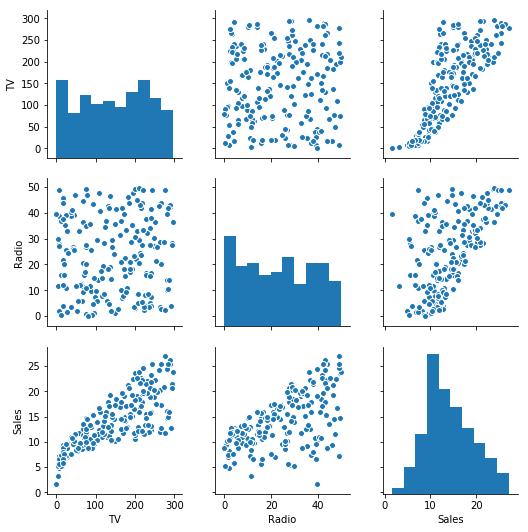

In [8]:
sns.pairplot(data[['TV','Radio','Sales']])
plt.show()

Radio and Sales appear to be linear, if a little scattered. However, TV and Sales appear to have a quadratic relationship, so it appears I will need to do a transformation. Fortunately, I already created non-linear transformed data columns in my features data frames. I'll graph the features again, this time using the square root of the TV varaible.

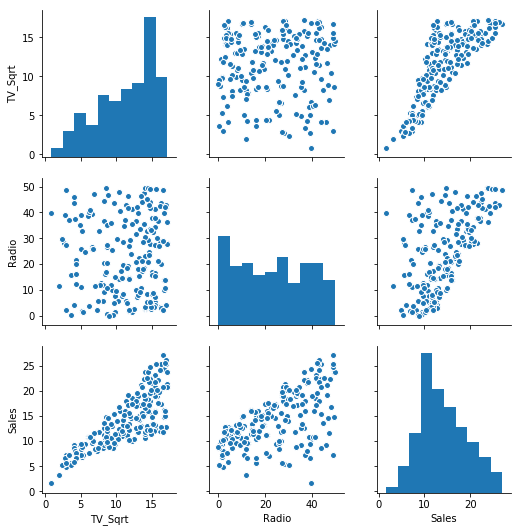

In [9]:
sns.pairplot(features[['TV_Sqrt','Radio','Sales']])
plt.show()

This looks much more linear, and is probably the best transformation we can do without investing more time than necessary.

I'll refit the model, this time with the square root of TV, and no Newspaper variable.

In [10]:
# Instantiate and fit the model.
regr = linear_model.LinearRegression()
Y = features['Sales'].values.reshape(-1, 1)
X = features[['TV_Sqrt','Radio']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = features['Sales']

residual = actual - predicted


Coefficients: 
 [[0.97485384 0.1944958 ]]

Intercept: 
 [-1.617931]

R-squared:
0.9289507061869382


The R squared value of my model has already gone up more than 2 percent, showing I am imporving the modeling of my data.

# Assumption: Error Normality

This assumption states the error of the model needs to be normally distributed. The error is calculated by subtracting the predicted value from the actual value. I can check it's distribution. 

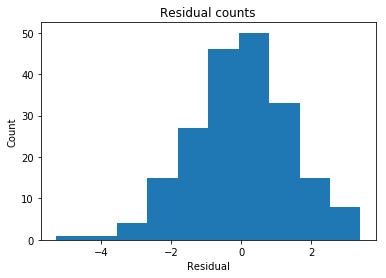

In [11]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

The error is close, but it appears to be slight off. It seems like ther

In [12]:
display(features[['Sales','TV_Sqrt','Radio']].describe())

,Sales,TV_Sqrt,Radio
count,200.000,200.000,200.000
mean,14.023,11.402,23.264
std,5.217,4.137,14.847
min,1.600,0.837,0.000
25%,10.375,8.624,9.975
50%,12.900,12.237,22.900
75%,17.400,14.793,36.525
max,27.000,17.216,49.600


There error is close, but it appears to be slightly off. There seems to be an outlier in the data thats warpign the residual results. Looking at the decribe function of the features data frame, we can see that is the case. I can find the row and omit it from features, better normalizing my results.

In [13]:
display(features[features['Sales']==features['Sales'].min()])

,Sales,TV,Radio,Newspaper,Sales_Sqrt,TV_Sqrt,Radio_Sqrt,Newspaper_Sqrt
130,1.600,0.700,39.600,8.700,1.265,0.837,6.293,2.950


In [14]:
features = features.drop(features.index[130])


Coefficients: 
 [[0.95740781 0.19670508]]

Intercept: 
 [-1.44266147]

R-squared:
0.9324441964838746


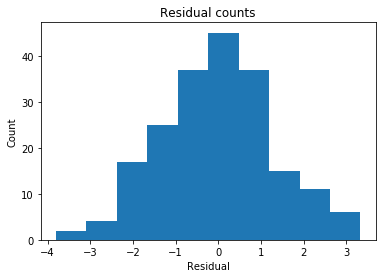

In [15]:
#Rerun the Linear Regression
Y = features['Sales'].values.reshape(-1, 1)
X = features[['TV_Sqrt','Radio']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = features['Sales']

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Great! The data appears to be much more normally distributed now.

# Assumption: Homoscedasticity

This assumption states that the error needs to be equally distributed across different sizes of predicted values. So, there can't be more or less variance in small predicted sales versus larger predicted sales, and anywhere in between. I can inspect the scedasticity of the model.

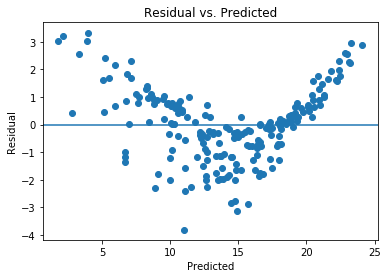

In [16]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Unfortunately, the model appears to be slightly heteroscedastic; the error is not equally distributed across prediction sizes. The shape of the error distribution leads me to believe that the Sales value might benefit from a square root transformation. 

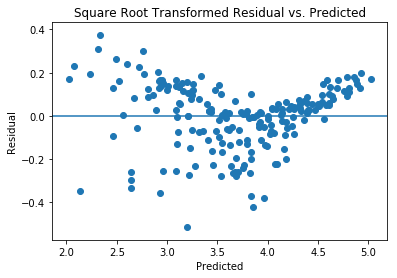

In [17]:
#Run model with square-root product transformation
A = features['Sales_Sqrt'].values.reshape(-1, 1)
B = features[['TV_Sqrt','Radio']]

regr.fit(B, A)

predicted_new = regr.predict(B).ravel()
actual_new = features['Sales_Sqrt']
residual_new = actual_new - predicted_new

plt.scatter(predicted_new, residual_new)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Square Root Transformed Residual vs. Predicted')
plt.show()

There error seems to be a little more evenly distributed now, but it is still not homoscedastic. The uneven distribution of the data might be caused by a relationship between the 2 variables and/or the outcome not captured by correlation. I can account for this in the model by adding the product of my 2 current variables, the square root of TV add spending and Radio ad spending.

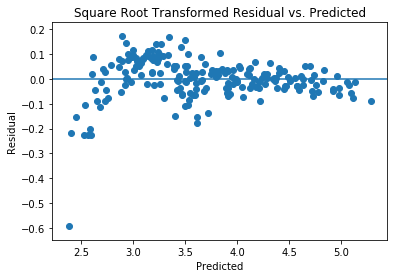

In [18]:
features['Product1'] = features['TV_Sqrt']*features['Radio']

#Run model with new product varible
A = features['Sales_Sqrt'].values.reshape(-1, 1)
B = features[['TV_Sqrt','Radio','Product1']]


regr.fit(B, A)

predicted_new = regr.predict(B).ravel()
actual_new = features['Sales_Sqrt']
residual_new = actual_new - predicted_new


plt.scatter(predicted_new, residual_new)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Square Root Transformed Residual vs. Predicted')
plt.show()

The error is much more evenly distriubted now, though it seems to be marred by one outlying data point, which I can remove.

In [19]:
#Find outlier data point
display(residual_new[residual_new==residual_new.min()])

155   -0.594
Name: Sales_Sqrt, dtype: float64

In [20]:
#Delete outlier datapoint
features = features.drop(features.index[154])

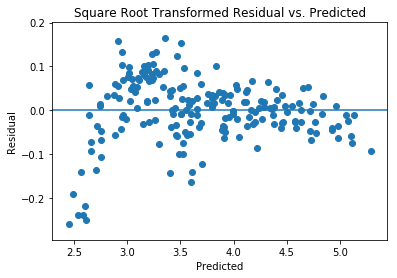

In [21]:
#Run outlier-free model
A = features['Sales_Sqrt'].values.reshape(-1, 1)
B = features[['TV_Sqrt','Radio','Product1']]


regr.fit(B, A)

predicted_new = regr.predict(B).ravel()
actual_new = features['Sales_Sqrt']
residual_new = actual_new - predicted_new


plt.scatter(predicted_new, residual_new)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Square Root Transformed Residual vs. Predicted')
plt.show()

Great! Looks perfect. Now, I'll see how these changes have affected my regression model. 

In [22]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(B, A))
print('\nRegrssion P-Values:')
lm = smf.ols('Sales_Sqrt ~ TV_Sqrt+Radio+Product1' , data=features).fit()
print(lm.pvalues)


Coefficients: 
 [[ 7.87009018e-02 -6.04053636e-06  2.18071303e-03]]

Intercept: 
 [2.20601512]

R-squared:
0.9886497244626461

Regrssion P-Values:
Intercept   0.000
TV_Sqrt     0.000
Radio       0.995
Product1    0.000
dtype: float64


The accuracy has gone way up, reaching greater than 98%, quite accurate. Interestingly, now that the product of the 2 variables has been introduced as a variable, the p-value of Radio has gone way up, near 1. This indicated Radio is having a near zero effect on the model meaning I can and should remove it. 

In [23]:
#Run model, this time without Radio
A = features['Sales_Sqrt'].values.reshape(-1, 1)
B = features[['TV_Sqrt','Product1']]

regr.fit(B, A)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(B, A))
print('\nRegrssion P-Values:')
lm = smf.ols('Sales_Sqrt ~ TV_Sqrt+Product1' , data=features).fit()
print(lm.pvalues)


Coefficients: 
 [[0.07871243 0.00218024]]

Intercept: 
 [2.2058685]

R-squared:
0.9886497225390383

Regrssion P-Values:
Intercept   0.000
TV_Sqrt     0.000
Product1    0.000
dtype: float64


As expected, removing the Radio variable has had a near-zero impact on the accuracy of the model and has only made it lass complicated, thus more efficient. 

In fact, I have increased the efficiency and accuracy of this model tremendulous, increasing the R squared value by more than 8%  while also decreasing the amount of no target variables by 1/3 (from 3 to 2). Truly there is a lot of power in how data is presented and what features are chosen when it comes to regression and modeling.